# 多目的最適化の高速計算

[前回のチュートリアル](./tutorial_multi.ipynb) では、各目的関数を独立にガウス過程回帰し、パレート超体積を直接最大化していました。この方法は、目的関数の数が多い場合に計算時間が膨大になります。

本チュートリアルでは、複数の目的関数を一つの目的関数に統合し、それをベイズ最適化することで、多目的最適化を高速に行う方法を学びます。

## 多目的最適化の統合

$i$ 番目のデータ点（特徴量）を $\vec{x}_i$ とし、その点での目的関数の値を $\vec{y}_i = (y_{i,1}, y_{i,2}, \dots, y_{i,p})$ とします。
$\vec{y}_i$ から新たな目的関数 $z_i$ を作り、 $\vec{x}_i$ から $z_i$ への関数 $z_i = g(\vec{x}_i)$ をガウス過程回帰でモデリングし、ベイズ最適化を行います。

現在の PHYSBO では、 $\vec{y}_i$ から $z_i$ を作る方法として、非優越ソート法とParEGO法が提供されています。

### 非優越ソート法

#### 定義

非優越ソート法 (Non-dominated Sorting; NDS) は、学習データ $\vec{y}_i$ について非優越ソートによるランク付けを行い、そのランクに基づいた目的関数を新たに作る手法です。ランクは以下のように再帰的に定義されます。

1. 学習データ全体のパレート解となる点のランクは $r_i = 1$ である。
2. 学習データからランク $r_i = 1$ となる点を除いた残りのデータのパレート解となる点のランクは $r_i = 2$ である。
3. 同様に、学習データからランク $r_i = 1,2,\dots,k-1$ となる点を除いた残りのデータのパレート解となる点のランクは $r_i = k$ である。
4. 最大ランク $r_\text{max}$ に達するまで、同様の操作を繰り返す。残った点は $r_i = \infty$ となる。

ランク $r_i$ に基づいて、新たな目的関数 $z_i$ を以下のように定義し、最大化します。

$$
z_i = \frac{1}{r_i}
$$

#### PHYSBOでの使い方

PHYSBOでは、 `physbo.search.unify.NDS` クラスとして NDS 法を実装しています。

``` python
unify_method = physbo.search.unify.NDS(rank_max=10)
```

`rank_max` はランクの最大値です。 これ以上のランクを持つ点については、 $z_i = 0$ として処理されます。

### ParEGO 法

#### 定義

ParEGO法は、目的関数の値について重み付き和と重み付き最大値をとることで、多目的最適化を単目的最適化に帰着させる方法です。
目的関数の重みを $\vec{w} = (w_1, w_2, \dots, w_p)$ とし、和と最大値の重みをそれぞれ $\rho_\text{sum}$ と $\rho_\text{max}$ とすると、新たな目的関数は

$$
z_i = \rho_\text{sum} \sum_{j} w_j y_{i,j} + \rho_\text{max} \max_{j} w_j y_{i,j}
$$

となります。

#### PHYSBO での使い方

PHYSBOでは、 `physbo.search.unify.ParEGO` クラスとして ParEGO 法を実装しています。

``` python
unify_method = physbo.search.unify.ParEGO(weight_sum=0.05, weight_max=1.0, weights=None, weights_discrete=0)
```

`weight_sum` と `weight_max` はそれぞれ $\rho_\text{sum}$ と $\rho_\text{max}$ に対応します。
`weights` には重み $\vec{w}$ を指定します。

- 重み $\vec{w}$ は $\sum_{j} w_j = 1$ として自動的に規格化されます。
- `weights = None` とすると、ベイズ最適化のステップごとに重みを乱数で生成します。
  - `weights_discrete` に整数 $s>0$ を指定すると、それぞれの重みが $w_j = \frac{a_j}{s}$ となるように生成されます。
    - ここで、 $a_j$ は $0, 1, \dots, s$ で、なおかつ $\sum_{j} a_j = s$ です。
  - $s=0$ の場合は、 $[0,1)$ の範囲で一様ランダムに重みを生成し、和が1になるように規格化されます。

また、 $y_{i,j}$ は目的関数 $j$ ごとに、学習データの最小値と最大値を用いて $[-1, 0]$ の範囲に正規化されます。

## チュートリアル

### 前準備

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import physbo
%matplotlib inline

seed = 12345
num_random_search = 10
num_bayes_search = 40

#### テスト関数

本チュートリアルでは引き続き、多目的最適化のベンチマーク関数である VLMOP2 を利用します。
なお、PHYSBO では `physbo.test_functions.multi_objective` に、VLMOP2を含めたいくつかの多目的最適化のベンチマーク関数が用意されています。

In [2]:
sim_fn = physbo.test_functions.multi_objective.VLMOP2(dim=2)

#### 探索候補データの準備

`sim_fn` は探索空間の最小値と最大値を `min_X` と `max_X` に持ちます。
これらを用いて、 `physbo.search.utility.make_grid` で探索候補点のグリッドを生成します。

In [3]:
test_X = physbo.search.utility.make_grid(min_X=sim_fn.min_X, max_X=sim_fn.max_X, num_X=101)

#### simulator の定義

In [4]:
simu = physbo.search.utility.Simulator(test_X=test_X, test_function=sim_fn)

#### HVPI

比較対象として、HVPIを用いたベイズ最適化を行います。

In [5]:
policy = physbo.search.discrete_multi.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(seed)

policy.random_search(max_num_probes=num_random_search, simulator=simu, is_disp=False)
time_start = time.time()
res_HVPI = policy.bayes_search(max_num_probes=num_bayes_search, simulator=simu, score='HVPI', interval=10, is_disp=False)
time_HVPI = time.time() - time_start
time_HVPI

4.317495107650757

Text(0.5, 1.0, 'HVPI')

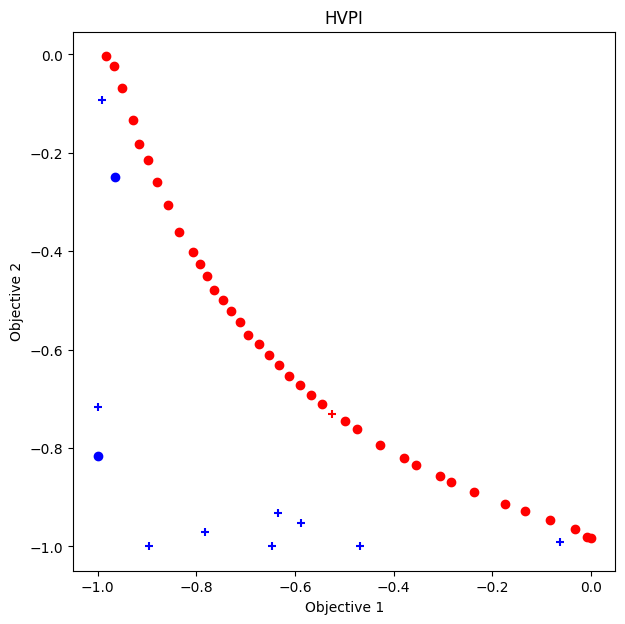

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
physbo.search.utility.plot_pareto_front_all(res_HVPI, ax=ax, steps_end=num_random_search, marker="+")
physbo.search.utility.plot_pareto_front_all(res_HVPI, ax=ax, steps_begin=num_random_search)
ax.set_title("HVPI")

In [7]:
VID_HVPI = res_HVPI.pareto.volume_in_dominance([-1,-1],[0,0])
VID_HVPI

np.float64(0.3285497837573861)

### ベイズ最適化

`Policy` クラスは `physbo.search.discrete_unified.Policy` を利用します。

他の `Policy` と同じく、 `random_search` などで初期データを作成し、 `bayes_search` メソッドでベイズ最適化を行います。
他の `Policy` との違いは以下の通りです。

#### 目的関数の単一化

単一化に使うアルゴリズムは `bayes_search` の `unify_method` 引数で指定します。
PHYSBO では `physbo.search.unify.ParEGO` と `physbo.search.unify.NDS` が用意されています。

#### 獲得関数

獲得関数は単目的最適化のものと同じです。

- PI (Probability of Improvement)
- EI (Expected Improvement)
- TS (Thompson Sampling)


### 非優越ソート

In [8]:
policy = physbo.search.discrete_unified.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(seed)

unify_method = physbo.search.unify.NDS(num_objectives=2)

policy.random_search(max_num_probes=num_random_search, simulator=simu, is_disp=False)
time_start = time.time()
res_NDS = policy.bayes_search(max_num_probes=num_bayes_search, simulator=simu, unify_method=unify_method, score='EI', interval=10, is_disp=False)
time_NDS = time.time() - time_start
time_NDS

1.830704927444458

#### パレート解のプロット

Text(0.5, 1.0, 'NDS')

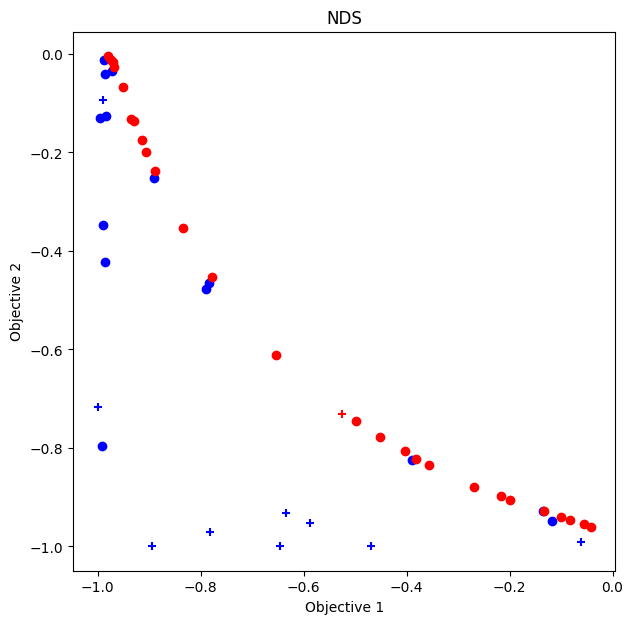

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))
physbo.search.utility.plot_pareto_front_all(res_NDS, ax=ax, steps_end=num_random_search, marker="+")
physbo.search.utility.plot_pareto_front_all(res_NDS, ax=ax, steps_begin=num_random_search)
ax.set_title("NDS")

#### 劣解領域体積

In [10]:
VID_NDS = res_NDS.pareto.volume_in_dominance([-1,-1],[0,0])
VID_NDS

np.float64(0.30923409715730354)

### ParEGO

In [11]:
policy = physbo.search.discrete_unified.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(seed)

unify_method = physbo.search.unify.ParEGO(num_objectives=2)

res_random = policy.random_search(max_num_probes=num_random_search, simulator=simu, is_disp=False)
time_start = time.time()
res_ParEGO = policy.bayes_search(max_num_probes=num_bayes_search, simulator=simu, unify_method=unify_method, score='EI', interval=10, is_disp=False)
time_ParEGO = time.time() - time_start
time_ParEGO

1.7820510864257812

#### パレート解のプロット

Text(0.5, 1.0, 'ParEGO')

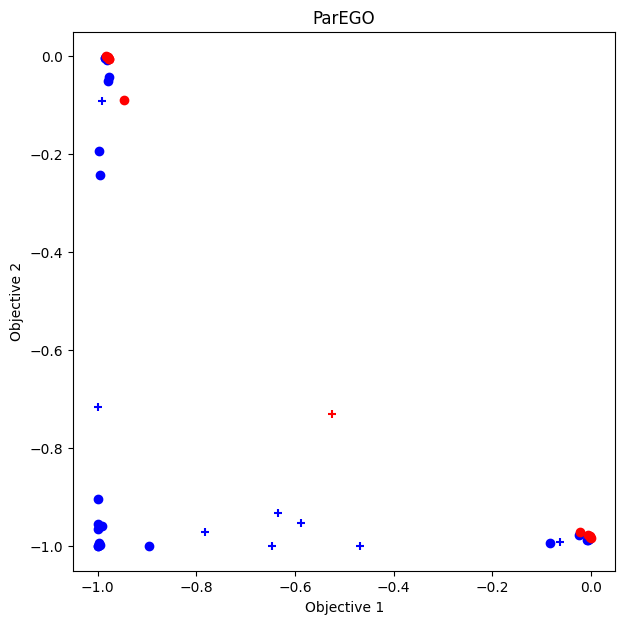

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
physbo.search.utility.plot_pareto_front_all(res_ParEGO, ax=ax, steps_end=num_random_search, marker="+")
physbo.search.utility.plot_pareto_front_all(res_ParEGO, ax=ax, steps_begin=num_random_search)
ax.set_title("ParEGO")

#### 劣解領域体積

In [13]:
VID_ParEGO = res_ParEGO.pareto.volume_in_dominance([-1,-1],[0,0])
VID_ParEGO

np.float64(0.18004551161609372)

### 比較

In [14]:
# make table
df = pd.DataFrame({
    "アルゴリズム": ["NDS", "ParEGO", "HVPI"],
    "計算時間": [time_NDS, time_ParEGO, time_HVPI],
    "劣解領域体積": [VID_NDS, VID_ParEGO, VID_HVPI]
})
df


アルゴリズム      計算時間    劣解領域体積
0     NDS  1.830705  0.309234
1  ParEGO  1.782051  0.180046
2    HVPI  4.317495  0.328550

NDS は HVPI と比較しても遜色ない結果（劣解領域体積）を、より短い計算時間で得ることができています。

一方のParEGOは、計算時間こそ短いですが、劣解領域体積が小さくなっています。

最適化問題によって、どのアルゴリズムがよい結果を出すかは変わります。

### 別のベンチマーク関数

Kita-Yabumoto-Mori-Nishikawa 関数を用いたベイズ最適化を行います。

$$
\begin{cases}
f_1(x, y) = -x^2 + y^2 \\
f_2(x, y) = 0.5x + y + 1 \\
\end{cases}
$$

の2つの目的関数を最大化する問題です。

また、 $x$ と $y$ には

$$
\begin{cases}
g_1(x, y) = 6.5 - x/6 - y \ge 0 \\
g_2(x, y) = 7.5 - x/2 - y \ge 0 \\
g_3(x, y) = 30 - 5x - y \ge 0 \\
\end{cases}
$$

という制約条件があります。


Kita, H., Yabumoto, Y., Mori, N., Nishikawa, Y. (1996). Multi-objective optimization by means of the thermodynamical genetic algorithm. In: Voigt, HM., Ebeling, W., Rechenberg, I., Schwefel, HP. (eds) Parallel Problem Solving from Nature — PPSN IV. PPSN 1996. Lecture Notes in Computer Science, vol 1141. Springer, Berlin, Heidelberg. https://doi.org/10.1007/3-540-61723-X_1014



In [15]:
fn_KYMN = physbo.test_functions.multi_objective.KitaYabumotoMoriNishikawa()
test_X_KYMN = physbo.search.utility.make_grid(min_X=fn_KYMN.min_X, max_X=fn_KYMN.max_X, num_X=101, constraint=fn_KYMN.constraint)
simu_KYMN = physbo.search.utility.Simulator(test_X=test_X_KYMN, test_function=fn_KYMN)

#### HVPI

Text(0.5, 1.0, 'HVPI')

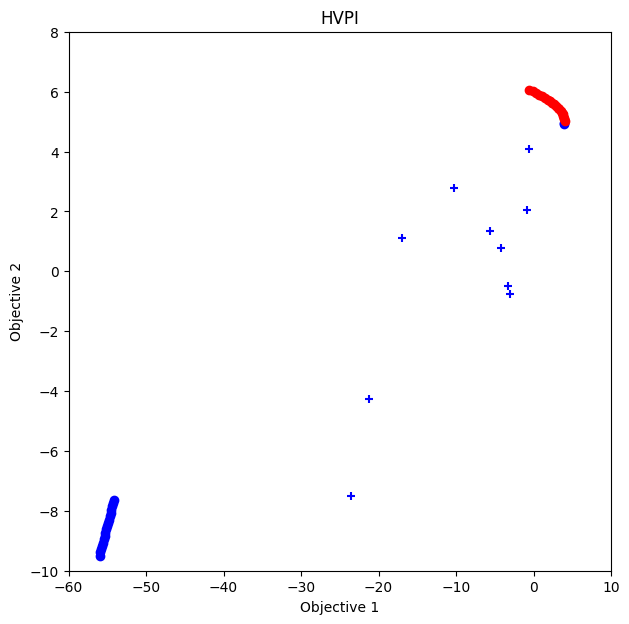

In [16]:
policy = physbo.search.discrete_multi.Policy(test_X=test_X_KYMN, num_objectives=2)
policy.set_seed(seed)

policy.random_search(max_num_probes=num_random_search, simulator=simu_KYMN, is_disp=False)
time_start = time.time()
res_KYMN_HVPI = policy.bayes_search(max_num_probes=num_bayes_search, simulator=simu_KYMN, score='HVPI', interval=10, is_disp=False)
time_KYMN_HVPI = time.time() - time_start
VID_KYMN_HVPI = res_KYMN_HVPI.pareto.volume_in_dominance(fn_KYMN.reference_min, fn_KYMN.reference_max)
VID_KYMN_HVPI
fig, ax = plt.subplots(figsize=(7, 7))
physbo.search.utility.plot_pareto_front_all(res_KYMN_HVPI, ax=ax, steps_end=num_random_search, marker="+")
physbo.search.utility.plot_pareto_front_all(res_KYMN_HVPI, ax=ax, steps_begin=num_random_search)
ax.set_xlim(-60, 10)
ax.set_ylim(-10, 8)
ax.set_title("HVPI")

#### ParEGO

Text(0.5, 1.0, 'ParEGO')

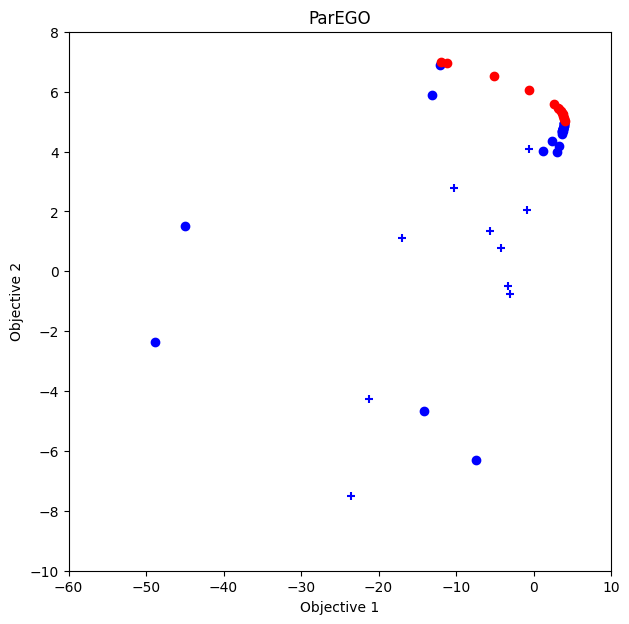

In [17]:
policy = physbo.search.discrete_unified.Policy(test_X=test_X_KYMN, num_objectives=2)
policy.set_seed(seed)

unify_method = physbo.search.unify.ParEGO(num_objectives=2)

policy.random_search(max_num_probes=num_random_search, simulator=simu_KYMN, is_disp=False)
time_start = time.time()
res_KYMN_ParEGO = policy.bayes_search(max_num_probes=num_bayes_search, simulator=simu_KYMN, unify_method=unify_method, score='EI', interval=10, is_disp=False)
time_KYMN_ParEGO = time.time() - time_start
VID_KYMN_ParEGO = res_KYMN_ParEGO.pareto.volume_in_dominance(fn_KYMN.reference_min, fn_KYMN.reference_max)
VID_KYMN_ParEGO
fig, ax = plt.subplots(figsize=(7, 7))
physbo.search.utility.plot_pareto_front_all(res_KYMN_ParEGO, ax=ax, steps_end=num_random_search, marker="+")
physbo.search.utility.plot_pareto_front_all(res_KYMN_ParEGO, ax=ax, steps_begin=num_random_search)
ax.set_xlim(-60, 10)
ax.set_ylim(-10, 8)
ax.set_title("ParEGO")


#### NDS

In [18]:
policy = physbo.search.discrete_unified.Policy(test_X=test_X_KYMN, num_objectives=2)
policy.set_seed(seed)

unify_method = physbo.search.unify.NDS(num_objectives=2)

policy.random_search(max_num_probes=num_random_search, simulator=simu_KYMN, is_disp=False)
time_start = time.time()
res_KYMN_NDS = policy.bayes_search(max_num_probes=num_bayes_search, simulator=simu_KYMN, unify_method=unify_method, score='EI', interval=10, is_disp=False)
time_KYMN_NDS = time.time() - time_start
VID_KYMN_NDS = res_KYMN_NDS.pareto.volume_in_dominance(fn_KYMN.reference_min, fn_KYMN.reference_max)
VID_KYMN_NDS
fig, ax = plt.subplots(figsize=(7, 7))
physbo.search.utility.plot_pareto_front_all(res_KYMN_NDS, ax=ax, steps_end=num_random_search, marker="+")
physbo.search.utility.plot_pareto_front_all(res_KYMN_NDS, ax=ax, steps_begin=num_random_search)
ax.set_xlim(-60, 10)
ax.set_ylim(-10, 8)
ax.set_title("NDS")


Text(0.5, 1.0, 'NDS')

#### 比較

In [19]:
pd.DataFrame({
    "アルゴリズム": ["NDS", "ParEGO", "HVPI"],
    "計算時間": [time_KYMN_NDS, time_KYMN_ParEGO, time_KYMN_HVPI],
    "劣解領域体積": [VID_KYMN_NDS, VID_KYMN_ParEGO, VID_KYMN_HVPI]
})


アルゴリズム      計算時間      劣解領域体積
0     NDS  1.769309  970.781427
1  ParEGO  1.763690  975.909589
2    HVPI  3.961754  932.139351

この最適化問題では、 ParEGOがよい結果を出しています。